# 4.4 模型选择、欠拟合和过拟合

In [1]:
#如何发现可以泛化的模式是机器学习的根本问题。
#将模型在训练数据上拟合的比在潜在分布中更接近的现象称为过拟合，用于对抗过拟合的技术称为正则化。

## 4.4.1 训练误差和泛化误差

In [2]:
#训练误差是指模型在训练数据集上计算得到的误差。
#泛化误差是指模型应用在同样从原始样本的分布中抽取的无限多样本数据时，模型误差的期望。

### 4.4.1.1 统计学习理论

In [3]:
#独立同分布假设意味着对数据进行采样的过程没有进行“记忆”。

### 4.4.1.2 模型复杂性

In [4]:
#影响模型泛化的因素：
#1.可调整参数的数量。当可调整参数的数量（有时称为自由度）很大时，模型往往更容易过拟合；
#2.参数采用的值。当权重的取值范围较大时，模型可能更容易过拟合。
#3.训练样本的数量。即使你的模型很简单，也很容易过拟合只包含一两个样本的数据集。而过拟合一个有数百万个样本的数据集则需要一个极其灵活的模型。

## 4.4.2 模型选择

### 4.4.2.1 验证集

In [5]:
#将数据分成三份，分别是训练集、测试集和验证集。

### 4.4.2.2 K折交叉验证

In [6]:
#原始数据被分成K个不重叠的子集，然后执行K次模型训练和验证，每次在K-1个子集上进行训练，并在剩余的一个子集（在该轮中没有用于训练的子集）上验证。
#最后，通过对K次实验的结果取平均来估计训练和验证误差。

## 4.4.3 欠拟合还是过拟合？

In [7]:
#欠拟合：训练误差和验证误差都很严重。
#过拟合：训练误差明显低于验证误差。
#是否过拟合或欠拟合可能取决于模型复杂性和可用训练数据集的大小。

### 4.4.3.1 模型复杂性

### 4.4.3.2 数据集大小

## 4.4 多项式回归

In [8]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

D:\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### 4.4.4.1 生成数据集

In [9]:
#噪声项服从均值为0且标准差为0.1的正态分布。
#训练集和测试集各生成100个样本。

max_degree = 20  #多项式的最大阶数
n_train, n_test = 100, 100  #训练和测试数据集大小
true_w = np.zeros(max_degree) # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n) = (n-1)!
#labels的维度：(n_train+n_test)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [10]:
# Numpy ndarray转化为tensor
true_w, features, poly_features,labels = [torch.tensor(x, dtype=
    torch.float) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.0809],
         [-0.3390]]),
 tensor([[ 1.0000e+00,  8.0893e-02,  3.2718e-03,  8.8223e-05,  1.7841e-06,
           2.8865e-08,  3.8916e-10,  4.4972e-12,  4.5474e-14,  4.0872e-16,
           3.3063e-18,  2.4314e-20,  1.6390e-22,  1.0199e-24,  5.8930e-27,
           3.1780e-29,  1.6067e-31,  7.6455e-34,  3.4359e-36,  1.4629e-38],
         [ 1.0000e+00, -3.3902e-01,  5.7466e-02, -6.4939e-03,  5.5039e-04,
          -3.7318e-05,  2.1086e-06, -1.0212e-07,  4.3275e-09, -1.6301e-10,
           5.5263e-12, -1.7032e-13,  4.8117e-15, -1.2548e-16,  3.0386e-18,
          -6.8675e-20,  1.4551e-21, -2.9018e-23,  5.4653e-25, -9.7518e-27]]),
 tensor([5.2307, 4.2194]))

### 4.4.4.2 对模型进行训练和测试

In [11]:
#实现一个函数来评估模型在给定数据集上的损失
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 损失的总和，样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [14]:
#定义训练函数
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 4.4.4.3 三阶多项书函数拟合（正常）

weight: [[ 4.9972477  1.1871903 -3.4020066  5.620113 ]]


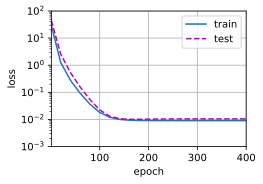

In [15]:
#首先使用三阶多项式函数，它与数据生成函数的阶数相同。 结果表明，该模型能有效降低训练损失和测试损失。 

# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### 4.4.4.5 线性函数拟合（欠拟合）

weight: [[3.05567  4.425996]]


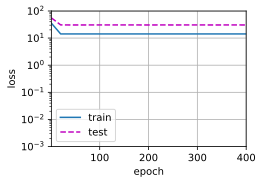

In [16]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### 4.4.4.5 高阶多项式的函数拟合（过拟合）

weight: [[ 4.9939466   1.2811552  -3.410851    5.1930304  -0.01701731  0.97692394
   0.39613864  0.02107654 -0.14408101 -0.12992153  0.04585711  0.18594435
  -0.19522241  0.21312922 -0.07934903  0.14906672 -0.1733877   0.18159115
  -0.0802365   0.18846461]]


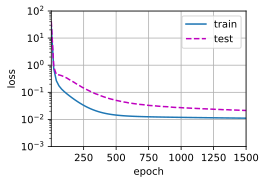

In [17]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

## 4.4.5 小结

In [18]:
#欠拟合是指模型无法继续减少训练误差，过拟合是指训练误差远小于验证误差。
#由于不能基于巽离岸误差来估计泛化误差，因此简单地最小化训练误差不一定意味着泛化误差的减小。
#机器学习模型需要防止过拟合，即防止泛化误差过大。
#验证集可以用于模型选择，但不能随意地使用它。
#我们应该选择一个复杂度适当的模型，避免使用数量不足的训练样本。